<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/QCNN_Jet_classifcationt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Install necessary libraries
!pip install pennylane h5py --quiet

In [17]:
# Standard imports
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pennylane as qml
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
from dataclasses import dataclass
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from google.colab import drive
drive.mount('/content/drive')
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
@dataclass
class Config:
    SAMPLES: int = 10000
    NUM_QUBITS: int = 6  # Number of qubits for QCNN
    Q_DEPTH: int = 4  # Depth of quantum layers
    ENCODING_SCHEME: str = 'amplitude'  # Encoding scheme for input data
    USE_ANALYTIC_GRADIENTS: bool = True
    INNER_STEPS: int = 5
    INNER_LR: float = 0.005
    OUTER_LR: float = 0.0005
    META_TASK_TYPE: str = 'both'
    META_BIN_COUNT: int = 8
    META_TASK_STRATEGY: str = 'binning'
    SUPPORT_SIZE: int = 16
    QUERY_SIZE: int = 16
    EPOCHS: int = 10
    BATCH_SIZE: int = 16
    EVAL_METRICS: bool = True
    USE_TEST2: bool = True
    SAVE_BEST_MODEL: bool = True
    CHECKPOINT_DIR: str = './checkpoints'

config = Config()

# Create checkpoint directory
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)

In [19]:
class JetDataset(Dataset):
    """Custom Dataset for loading jet images, labels, and additional features."""
    def __init__(self, X: np.ndarray, y: np.ndarray, pt: np.ndarray = None, m0: np.ndarray = None):
        self.X = X
        self.y = y
        self.pt = pt
        self.m0 = m0

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        return self.X[idx], self.y[idx]

# Load and merge datasets
def load_and_merge_datasets(config: Config) -> Tuple[Dataset, Dataset]:
    """Load and merge datasets for meta-task generation."""
    # Paths to datasets
    train_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_train-set_n793900.hdf5'
    test1_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_test-set_n139306.hdf5'
    test2_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_test-set_n10000.hdf5'

    # Load train and test1 datasets
    with h5py.File(train_path, 'r') as f:
        X_train = f['X_jets'][:config.SAMPLES]
        y_train = f['y'][:config.SAMPLES]
        pt_train = f['pt'][:config.SAMPLES]
        m0_train = f['m0'][:config.SAMPLES]

    with h5py.File(test1_path, 'r') as f:
        X_test1 = f['X_jets'][:config.SAMPLES]
        y_test1 = f['y'][:config.SAMPLES]
        pt_test1 = f['pt'][:config.SAMPLES]
        m0_test1 = f['m0'][:config.SAMPLES]

    # Merge train and test1
    X_meta = np.concatenate([X_train, X_test1], axis=0)
    y_meta = np.concatenate([y_train, y_test1], axis=0)
    pt_meta = np.concatenate([pt_train, pt_test1], axis=0)
    m0_meta = np.concatenate([m0_train, m0_test1], axis=0)

    # Load test2 dataset
    with h5py.File(test2_path, 'r') as f:
        X_test2 = f['X'][:config.SAMPLES]  # Use 'X' instead of 'X_jets'
        y_test2 = f['y'][:config.SAMPLES]

    # Create datasets
    meta_dataset = JetDataset(X_meta, y_meta, pt_meta, m0_meta)
    test2_dataset = JetDataset(X_test2, y_test2)

    return meta_dataset, test2_dataset

# Load datasets
meta_dataset, test2_dataset = load_and_merge_datasets(config)

In [20]:
# Generate meta-tasks
def generate_meta_tasks(
    dataset: Dataset,
    meta_task_type: str,
    bin_count: int,
    support_size: int,
    query_size: int,
    strategy: str = 'binning',
    num_tasks_per_bin: int = 3,  # Generate multiple tasks per bin
) -> List[Dict[str, Any]]:
    """
    Generate meta-tasks using both `pt` and `m0` features for diversity.
    """
    X, y = [], []
    for i in range(len(dataset)):
        X_sample, y_sample = dataset[i]
        # Flatten the input data to match the number of qubits
        X_sample = X_sample.flatten()

        # Pad or truncate the input data to match the required length for amplitude encoding
        required_length = 2 ** config.NUM_QUBITS
        if X_sample.size < required_length:
            padding = np.zeros(required_length - X_sample.size)
            X_sample = np.concatenate([X_sample, padding])
        elif X_sample.size > required_length:
            X_sample = X_sample[:required_length]

        X.append(X_sample)
        y.append(y_sample)
    X = np.array(X)
    y = np.array(y)

    meta_tasks = []
    bin_task_counts = []

    # Alternate between `pt` and `m0` for meta-task generation
    for feature_type in ['pt', 'm0']:
        feature = getattr(dataset, feature_type)
        bins = np.linspace(feature.min(), feature.max(), bin_count + 1)
        for i in range(len(bins) - 1):
            bin_indices = np.where((feature >= bins[i]) & (feature < bins[i + 1]))[0]
            if len(bin_indices) < support_size + query_size:
                continue

            class_0_indices = bin_indices[y[bin_indices] == 0]
            class_1_indices = bin_indices[y[bin_indices] == 1]

            if len(class_0_indices) < support_size // 2 or len(class_1_indices) < support_size // 2:
                continue

            for _ in range(num_tasks_per_bin):
                support_indices = np.concatenate([
                    np.random.choice(class_0_indices, support_size // 2, replace=False),
                    np.random.choice(class_1_indices, support_size // 2, replace=False)
                ])
                query_indices = np.concatenate([
                    np.random.choice(class_0_indices, query_size // 2, replace=False),
                    np.random.choice(class_1_indices, query_size // 2, replace=False)
                ])
                meta_tasks.append(
                    {
                        "support_X": torch.tensor(X[support_indices], dtype=torch.float32),
                        "support_y": torch.tensor(y[support_indices], dtype=torch.long),
                        "query_X": torch.tensor(X[query_indices], dtype=torch.float32),
                        "query_y": torch.tensor(y[query_indices], dtype=torch.long),
                    }
                )
            bin_task_counts.append(num_tasks_per_bin)

    print(f"Total meta-tasks generated: {len(meta_tasks)}")
    return meta_tasks

# Generate meta-tasks
meta_tasks = generate_meta_tasks(
    meta_dataset,
    config.META_TASK_TYPE,
    config.META_BIN_COUNT,
    config.SUPPORT_SIZE,
    config.QUERY_SIZE,
    config.META_TASK_STRATEGY,
)

Total meta-tasks generated: 36


In [21]:
class QCNNModel(nn.Module):
    def __init__(self, num_qubits: int, depth: int, encoding_scheme: str):
        super().__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.encoding_scheme = encoding_scheme
        self.dev = qml.device("default.qubit", wires=num_qubits)

        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs, weights):
            # Flatten the input tensor to ensure it is 1D
            inputs = inputs.flatten()

            # Ensure input size matches the required length for amplitude encoding
            required_length = 2 ** self.num_qubits
            if inputs.size(0) < required_length:
                # Pad the input tensor with zeros if it has fewer elements
                padding = torch.zeros(required_length - inputs.size(0), device=inputs.device)
                inputs = torch.cat([inputs, padding])
            elif inputs.size(0) > required_length:
                # Truncate the input tensor if it has more elements
                inputs = inputs[:required_length]

            # Input encoding
            if self.encoding_scheme == 'angle':
                for i in range(self.num_qubits):
                    qml.RY(inputs[i], wires=i)
            elif self.encoding_scheme == 'amplitude':
                qml.AmplitudeEmbedding(inputs, wires=range(self.num_qubits), normalize=True)
            else:
                raise ValueError("Invalid encoding scheme.")

            # Quantum convolutional layers
            for layer in range(self.depth):
                for i in range(self.num_qubits - 1):  # Apply entangling gates locally
                    qml.CNOT(wires=[i, i + 1])
                    qml.RY(weights[layer, i, 0], wires=i)
                    qml.RZ(weights[layer, i, 1], wires=i)
                    qml.RY(weights[layer, i, 2], wires=i)

            # Quantum pooling layer (reduce qubits)
            for i in range(self.num_qubits // 2):
                qml.CNOT(wires=[i, i + self.num_qubits // 2])
                qml.PauliX(wires=i + self.num_qubits // 2)

            # Final measurement
            return [qml.expval(qml.PauliZ(i)) for i in range(self.num_qubits // 2)]

        self.circuit = circuit
        self.weights = nn.Parameter(torch.randn(depth, num_qubits - 1, 3))
        self.fc = nn.Linear(num_qubits // 2, 2)  # Output layer for binary classification

    def forward(self, x):
        batch_size = x.size(0)
        outputs = torch.zeros(batch_size, self.num_qubits // 2)
        for i in range(batch_size):
            outputs[i] = torch.tensor(self.circuit(x[i], self.weights), dtype=torch.float32)
        logits = self.fc(outputs)
        return logits
# Instantiate the QCNN model
qcnn_model = QCNNModel(config.NUM_QUBITS, config.Q_DEPTH, config.ENCODING_SCHEME)

In [22]:
# Train the QCNN model
def train_qcnn(model, meta_tasks, config):
    optimizer = optim.Adam(model.parameters(), lr=config.OUTER_LR)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(config.EPOCHS):
        meta_loss = 0.0
        all_preds, all_labels = [], []

        for task in meta_tasks:
            support_X, support_y = task["support_X"], task["support_y"]
            query_X, query_y = task["query_X"], task["query_y"]

            # Inner-loop adaptation
            adapted_model = QCNNModel(config.NUM_QUBITS, config.Q_DEPTH, config.ENCODING_SCHEME)
            adapted_model.load_state_dict(model.state_dict())
            inner_optimizer = optim.SGD(adapted_model.parameters(), lr=config.INNER_LR)

            for _ in range(config.INNER_STEPS):
                inner_optimizer.zero_grad()
                logits = adapted_model(support_X)
                loss = loss_fn(logits, support_y)
                loss.backward()
                inner_optimizer.step()

            # Outer-loop update
            optimizer.zero_grad()
            query_logits = adapted_model(query_X)
            query_loss = loss_fn(query_logits, query_y)
            query_loss.backward()
            optimizer.step()

            meta_loss += query_loss.item()

            # Collect predictions for metrics
            preds = torch.argmax(query_logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(query_y.cpu().numpy())

        meta_loss /= len(meta_tasks)
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
        recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
        f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)

        print(f"Epoch {epoch + 1}/{config.EPOCHS}, Meta-loss: {meta_loss:.4f}, "
              f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Train the QCNN model
train_qcnn(qcnn_model, meta_tasks, config)

Epoch 1/10, Meta-loss: nan, Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1-score: 0.3333
Epoch 2/10, Meta-loss: nan, Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1-score: 0.3333
Epoch 3/10, Meta-loss: nan, Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1-score: 0.3333
Epoch 4/10, Meta-loss: nan, Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1-score: 0.3333
Epoch 5/10, Meta-loss: nan, Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1-score: 0.3333
Epoch 6/10, Meta-loss: nan, Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1-score: 0.3333
Epoch 7/10, Meta-loss: nan, Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1-score: 0.3333
Epoch 8/10, Meta-loss: nan, Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1-score: 0.3333
Epoch 9/10, Meta-loss: nan, Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1-score: 0.3333
Epoch 10/10, Meta-loss: nan, Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1-score: 0.3333


Test Accuracy: 0.4992, Precision: 0.4935, Recall: 0.4992, F1-score: 0.3584
Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.97      0.66      5000
         1.0       0.49      0.03      0.06      5000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.36     10000
weighted avg       0.49      0.50      0.36     10000



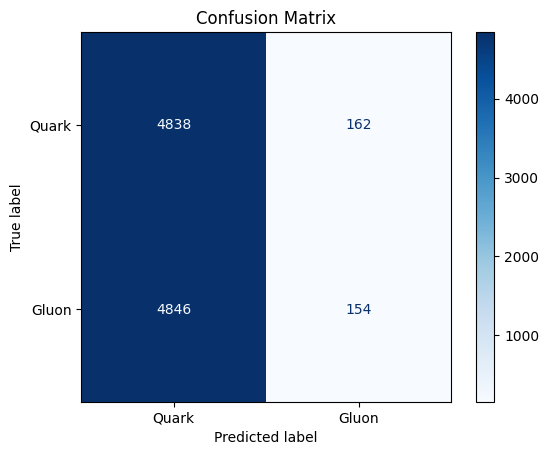

In [23]:
# Evaluate the QCNN model
def evaluate_qcnn(model, test_dataset, config):
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.permute(0, 3, 1, 2)  # Fix shape
            logits = model(X_batch)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)

    print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    # Classification report
    report = classification_report(all_labels, all_preds, zero_division=0)
    print("Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Quark", "Gluon"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate the QCNN model
evaluate_qcnn(qcnn_model, test2_dataset, config)